In [2]:
import zipfile
import os

zip_path = "/content/split_datax.zip"  # path to your zip file
extract_path = "/content/split_datax"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: /content/split_datax


In [ ]:
import os
import random
import shutil

dataset_path = "/content/ani5"   # original dataset
output_path = "/content/split_data"

query_path = os.path.join(output_path, "query")        # 10%
retrieval_path = os.path.join(output_path, "retrieval")# 90%

os.makedirs(query_path, exist_ok=True)
os.makedirs(retrieval_path, exist_ok=True)


code to split the data set into query and retrievel

In [ ]:
QUERY_PERCENT = 0.1  # 10%

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    num_query = int(len(images) * QUERY_PERCENT)

    query_images = images[:num_query]
    retrieval_images = images[num_query:]

    # create class folders
    os.makedirs(os.path.join(query_path, cls), exist_ok=True)
    os.makedirs(os.path.join(retrieval_path, cls), exist_ok=True)

    # copy query images
    for img in query_images:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(query_path, cls, img)
        )

    # copy retrieval images
    for img in retrieval_images:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(retrieval_path, cls, img)
        )

    print(f"{cls}: {len(query_images)} query | {len(retrieval_images)} retrieval")


farfalla: 211 query | 1901 retrieval
elefante: 144 query | 1302 retrieval
cavallo: 262 query | 2361 retrieval
gatto: 166 query | 1502 retrieval
cane: 486 query | 4377 retrieval


In [ ]:
import os

base_path = "/content/split_data"

rename_map = {
    "farfalla": "butterfly",
    "elefante": "elephant",
    "cavallo": "horse",
    "gatto": "cat",
    "cane": "dog"
}

for split in ["query", "retrieval"]:
    split_path = os.path.join(base_path, split)

    for old_name, new_name in rename_map.items():
        old_path = os.path.join(split_path, old_name)
        new_path = os.path.join(split_path, new_name)

        if os.path.exists(old_path):
            os.rename(old_path, new_path)
            print(f"{split}: {old_name} → {new_name}")
        else:
            print(f"{split}: {old_name} not found")


query: farfalla → butterfly
query: elefante → elephant
query: cavallo → horse
query: gatto → cat
query: cane → dog
retrieval: farfalla → butterfly
retrieval: elefante → elephant
retrieval: cavallo → horse
retrieval: gatto → cat
retrieval: cane → dog


In [ ]:
import zipfile
import os

zip_path = "/content/split_data.zip"  # path to your zip file
extract_path = "/content/split_datax"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

Dataset extracted to: /content/split_datax


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super(EmbeddingNet, self).__init__()

        self.convnet = nn.Sequential(
            # Block 1: 3 -> 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 128x128 -> 64x64

            # Block 2: 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64x64 -> 32x32

            # Block 3: 128 -> 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32x32 -> 16x16

            # Block 4: 256 -> 512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16 -> 8x8
        )

        self.fc = nn.Sequential(
            nn.Linear(512 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, embedding_dim)
        )

    def forward(self, x):
        x = self.convnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        #CRITICAL: L2 normalization for cosine similarity
        x = F.normalize(x, p=2, dim=1)

        return x


In [4]:
model = EmbeddingNet(embedding_dim=128)
x = torch.randn(4, 3, 128, 128)
out = model(x)

print("Output shape:", out.shape)
print("Vector norm:", out.norm(dim=1))


Output shape: torch.Size([4, 128])
Vector norm: tensor([1., 1., 1., 1.], grad_fn=<LinalgVectorNormBackward0>)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BatchHardTripletLoss(nn.Module):
    def __init__(self, margin=0.3):
        super(BatchHardTripletLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        """
        embeddings: Tensor of shape (batch_size, embedding_dim)
        labels: Tensor of shape (batch_size)
        """

        # Compute pairwise distance matrix (Euclidean)
        dist_matrix = torch.cdist(embeddings, embeddings, p=2)

        labels = labels.unsqueeze(1)
        mask_positive = (labels == labels.T)
        mask_negative = (labels != labels.T)

        # Remove self-comparisons from positives
        mask_positive.fill_diagonal_(False)

        # Hardest positive: max distance among positives
        hardest_positive_dist = (dist_matrix * mask_positive).max(dim=1)[0]

        # Hardest negative: min distance among negatives
        max_dist = dist_matrix.max().detach()
        dist_matrix_neg = dist_matrix + max_dist * (~mask_negative)
        hardest_negative_dist = dist_matrix_neg.min(dim=1)[0]

        # Triplet loss
        loss = F.relu(hardest_positive_dist - hardest_negative_dist + self.margin)

        return loss.mean()


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BatchHardTripletLoss(nn.Module):
    def __init__(self, margin=0.3):
        super(BatchHardTripletLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        """
        embeddings: Tensor of shape (batch_size, embedding_dim)
        labels: Tensor of shape (batch_size)
        """

        # Compute pairwise distance matrix (Euclidean)
        dist_matrix = torch.cdist(embeddings, embeddings, p=2)

        labels = labels.unsqueeze(1)
        mask_positive = (labels == labels.T)
        mask_negative = (labels != labels.T)

        # Remove self-comparisons from positives
        mask_positive.fill_diagonal_(False)

        # Hardest positive: max distance among positives
        hardest_positive_dist = (dist_matrix * mask_positive).max(dim=1)[0]

        # Hardest negative: min distance among negatives
        max_dist = dist_matrix.max().detach()
        dist_matrix_neg = dist_matrix + max_dist * (~mask_negative)
        hardest_negative_dist = dist_matrix_neg.min(dim=1)[0]

        # Triplet loss
        loss = F.relu(hardest_positive_dist - hardest_negative_dist + self.margin)

        return loss.mean()


In [7]:
import os
from PIL import Image
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.images = []
        self.labels = []

        self.class_to_idx = {
            cls_name: idx
            for idx, cls_name in enumerate(sorted(os.listdir(root_dir)))
        }

        for cls_name, label in self.class_to_idx.items():
            cls_path = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_path):
                self.images.append(os.path.join(cls_path, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


In [8]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

train_dataset = ImageDataset(
    root_dir="/content/split_datax/content/split_data/retrieval",
    transform=transform
)

val_dataset = ImageDataset(
    root_dir="/content/split_datax/content/split_data/query",
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)


In [9]:
import torch
import numpy as np
from PIL import Image
import os
import time
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmbeddingNet(embedding_dim=128).to(device)
model.load_state_dict(torch.load("best_embedding_model.pth", map_location=device))
model.eval()


FileNotFoundError: [Errno 2] No such file or directory: 'best_embedding_model.pth'

In [10]:
import os

os.listdir()


['.config', 'drive', 'split_datax.zip', 'split_datax', 'sample_data']

In [ ]:
torch.save(model.state_dict(), "best_embedding_model.pth")


In [12]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmbeddingNet(embedding_dim=128).to(device)
criterion = BatchHardTripletLoss(margin=0.3)
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

num_epochs = 25
best_val_loss = float("inf")

In [48]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmbeddingNet(embedding_dim=128).to(device)
criterion = BatchHardTripletLoss(margin=0.3)
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

num_epochs = 25
best_val_loss = float("inf")

for epoch in range(num_epochs):
    # -------- TRAIN --------
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        embeddings = model(images)
        loss = criterion(embeddings, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            embeddings = model(images)
            loss = criterion(embeddings, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f}")

    # -------- SAVE BEST MODEL --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_embedding_modelX!.pth")
        print(" Best model saved")


Epoch [1/25] | Train Loss: 0.3064 | Val Loss: 0.2990
 Best model saved
Epoch [2/25] | Train Loss: 0.3016 | Val Loss: 0.2994
Epoch [3/25] | Train Loss: 0.3009 | Val Loss: 0.2995
Epoch [4/25] | Train Loss: 0.3006 | Val Loss: 0.2996
Epoch [5/25] | Train Loss: 0.3004 | Val Loss: 0.2996
Epoch [6/25] | Train Loss: 0.3003 | Val Loss: 0.2996
Epoch [7/25] | Train Loss: 0.3002 | Val Loss: 0.2996
Epoch [8/25] | Train Loss: 0.3002 | Val Loss: 0.2995
Epoch [9/25] | Train Loss: 0.3002 | Val Loss: 0.2995
Epoch [10/25] | Train Loss: 0.3001 | Val Loss: 0.2994
Epoch [11/25] | Train Loss: 0.2999 | Val Loss: 0.2991
Epoch [12/25] | Train Loss: 0.2998 | Val Loss: 0.2987
 Best model saved
Epoch [13/25] | Train Loss: 0.2998 | Val Loss: 0.2983
 Best model saved
Epoch [14/25] | Train Loss: 0.2996 | Val Loss: 0.2973
 Best model saved
Epoch [15/25] | Train Loss: 0.2994 | Val Loss: 0.2946
 Best model saved
Epoch [16/25] | Train Loss: 0.2985 | Val Loss: 0.2796
 Best model saved
Epoch [17/25] | Train Loss: 0.2990 | 

In [49]:
# Load the trained model
model = EmbeddingNet(embedding_dim=128).to(device)
model.load_state_dict(torch.load("/content/best_embedding_modelX.pth", map_location=device))
model.eval()

print(" Trained model loaded")


 Trained model loaded


In [50]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmbeddingNet(embedding_dim=128).to(device)
model.load_state_dict(torch.load("/content/best_embedding_modelX.pth", map_location=device))
model.eval()

print(" Final model loaded")


 Final model loaded


Build the Vector Database (Retrieval Set)

In [52]:
import os
from PIL import Image
import torch

def build_vector_db(model, data_dir, transform):
    embeddings, labels, paths = [], [], []

    with torch.no_grad():
        for cls in sorted(os.listdir(data_dir)):
            cls_path = os.path.join(data_dir, cls)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                img = Image.open(img_path).convert("RGB")
                img = transform(img).unsqueeze(0).to(device)

                emb = model(img).cpu()
                embeddings.append(emb)
                labels.append(cls)
                paths.append(img_path)

    embeddings = torch.cat(embeddings, dim=0)  # (N, 128)
    return embeddings, labels, paths

db_embeddings, db_labels, db_paths = build_vector_db(
    model,
    "/content/split_datax/content/split_data/retrieval",
    transform
)

print("Vector DB built:", db_embeddings.shape)


Vector DB built: torch.Size([11443, 128])


In [54]:
def top_k_search(query_emb, db_embeddings, k=5):
    sims = torch.matmul(db_embeddings, query_emb.T).squeeze()
    topk = torch.topk(sims, k=k).indices
    return topk


In [71]:
import time

def evaluate_system(model, query_dir, db_embeddings, db_labels, transform, k=5):
    total = top1 = top5 = 0
    precision_sum = 0
    start = time.time()

    for cls in os.listdir(query_dir):
        cls_path = os.path.join(query_dir, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path).convert("RGB")
            img = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                q_emb = model(img).cpu()

            idxs = top_k_search(q_emb, db_embeddings, k)
            preds = [db_labels[i] for i in idxs]

            total += 1
            if preds[0] == cls:
                top1 += 1
            if cls in preds:
                top5 += 1
            precision_sum += preds.count(cls) / k

    latency = (time.time() - start) / total

    return {
        "Top-1 Accuracy": top1 / total,
        "Top-5 Accuracy": top5 / total,
        "Precision@5": precision_sum / total,
        "Avg Latency (sec)": latency
    }

metrics = evaluate_system(
    model,
    "/content/split_datax/content/split_data/query",
    db_embeddings,
    db_labels,
    transform,
    k=5
)

for m, v in metrics.items():
    print(f"{m}: {v:.4f}")


Top-1 Accuracy: 0.7762
Top-5 Accuracy: 0.8503
Precision@5: 0.7677
Avg Latency (sec): 0.0048


In [56]:
# Warm-up (do once)
dummy_img = torch.randn(1, 3, 128, 128).to(device)
with torch.no_grad():
    _ = model(dummy_img)


In [57]:
import time
from PIL import Image

def measure_latency(model, img_path, transform, db_embeddings, k=5):
    start = time.time()

    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        query_emb = model(img).cpu()

    sims = torch.matmul(db_embeddings, query_emb.T).squeeze()
    _ = torch.topk(sims, k)

    end = time.time()
    return end - start


In [58]:
def average_latency(model, query_dir, transform, db_embeddings, k=5):
    times = []

    for cls in os.listdir(query_dir):
        cls_path = os.path.join(query_dir, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            t = measure_latency(model, img_path, transform, db_embeddings, k)
            times.append(t)

    return sum(times) / len(times)


In [72]:
avg_latency = average_latency(
    model,
    "/content/split_datax/content/split_data/query",
    transform,
    db_embeddings,
    k=5
)

print(f"Average Latency per query: {avg_latency:.6f} seconds")


Average Latency per query: 0.005275 seconds


In [60]:
def get_top5_similar_images(
    model,
    query_image_path,
    transform,
    db_embeddings,
    db_paths,
    k=5
):
    # Load and preprocess query image
    query_img = Image.open(query_image_path).convert("RGB")
    query_tensor = transform(query_img).unsqueeze(0).to(device)

    # Generate query embedding
    with torch.no_grad():
        query_embedding = model(query_tensor).cpu()

    # Cosine similarity (dot product since L2 normalized)
    similarities = torch.matmul(db_embeddings, query_embedding.T).squeeze()

    # Get Top-K indices
    topk_indices = torch.topk(similarities, k=k).indices.tolist()

    # Get image paths
    similar_image_paths = [db_paths[i] for i in topk_indices]

    return similar_image_paths


In [61]:
def show_results(query_image_path, similar_image_paths):
    plt.figure(figsize=(15, 4))

    # Show query image
    plt.subplot(1, 6, 1)
    plt.imshow(Image.open(query_image_path))
    plt.title("Query")
    plt.axis("off")

    # Show Top-5 similar images
    for i, img_path in enumerate(similar_image_paths):
        plt.subplot(1, 6, i + 2)
        plt.imshow(Image.open(img_path))
        plt.title(f"Top {i+1}")
        plt.axis("off")

    plt.show()


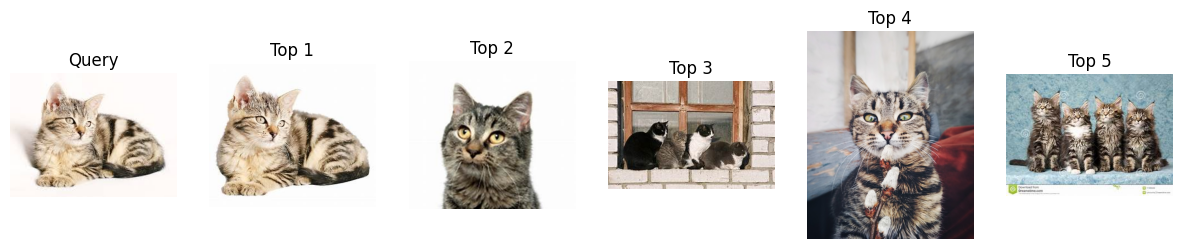

In [73]:
query_image_path = "/content/catxx.jpg"  # change this

top5_paths = get_top5_similar_images(
    model,
    query_image_path,
    transform,
    db_embeddings,
    db_paths,
    k=5
)

show_results(query_image_path, top5_paths)
